# Notebook Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
EXAMPLE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

## Reading Files

In [3]:
stream = open(EXAMPLE)
message = stream.read()
stream.close()
#print(message)

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE)
is_body  = False
lines = []

for line in stream:
    if is_body == True:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for x in range(N):
        yield x ** 2

In [7]:
for i  in generate_squares(12):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 25 -> 36 -> 49 -> 64 -> 81 -> 100 -> 121 -> 

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in os.walk(path):
       #print(filenames)
        for filename in filenames:
            filepath = os.path.join(root, filename)
            
            stream = open(filepath, encoding='latin-1')
            is_body  = False
            lines = []

            for line in stream:
                if is_body == True:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()
            
            email_body = '\n'.join(lines)
            yield filename, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names= []
    
    for filename, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        row_names.append(filename)
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire emails dataframe: ', data.shape)
data.head()


Shape of entire emails dataframe:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for Missing Values

In [15]:
data.MESSAGE.isna().values.any()

False

In [16]:
# checking for null values in messages 
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
# checking for number of messages with null values
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
data[data['MESSAGE'] == ''].index


Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [19]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [20]:
data.shape

(5799, 2)

In [21]:
data.drop(['cmds'], inplace=True)
data.shape

(5796, 2)

In [22]:
data.reset_index(inplace=True)

## Setting Row Index

In [23]:
data

,index,MESSAGE,CATEGORY
0,00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,1
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...,...
5791,01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
5792,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
5793,01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
5794,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0


In [24]:
data.rename(columns={'index':'FILE_NAME'}, inplace=True)

In [25]:
data

,FILE_NAME,MESSAGE,CATEGORY
0,00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,1
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...,...
5791,01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
5792,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
5793,01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
5794,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0


## Save File Using Pandas

In [26]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Emails Visualized

In [27]:
data[data.CATEGORY == 1].count()

FILE_NAME    1896
MESSAGE      1896
CATEGORY     1896
dtype: int64

In [28]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [29]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

# spam_and_ham = pd.DataFrame({'HAM':[amount_of_ham], 'SPAM':[amount_of_spam]})
# spam_and_ham

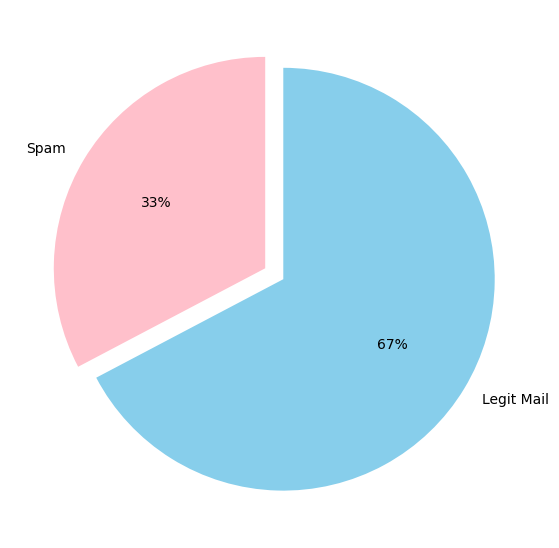

In [36]:
plt.figure(figsize=(15, 7), dpi=100)
plt.pie([amount_of_spam, amount_of_ham], labels=['Spam', 'Legit Mail'],
        autopct='%1.0f%%', explode=(0.05, 0.05), startangle=90, colors=['pink', 'skyblue'])
plt.show()

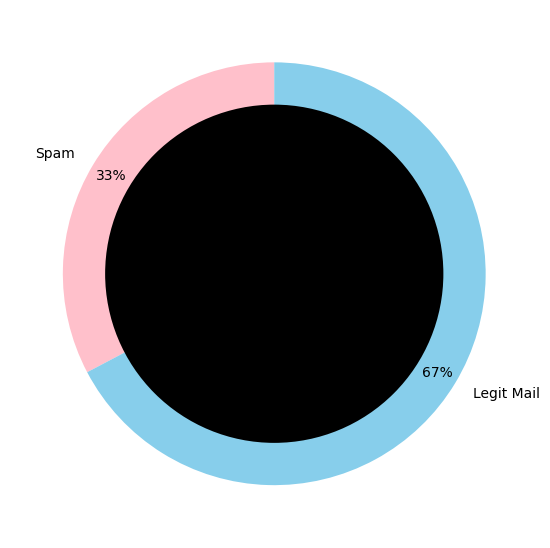

In [48]:
plt.figure(figsize=(15, 7), dpi=100)
plt.pie([amount_of_spam, amount_of_ham], labels=['Spam', 'Legit Mail'],
        autopct='%1.0f%%', startangle=90, colors=['pink', 'skyblue'], pctdistance=0.9)


center_circle = plt.Circle((0, 0), radius=0.8, fc='black')
plt.gca().add_artist(center_circle)

plt.show()